In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import seaborn as sns

In [2]:
data = pd.read_csv("minor_iad_3_15.csv")

# Иерархический метод

In [4]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist

data_hier = data.copy()
data_normalized = pd.DataFrame(preprocessing.normalize(data_hier, 
                                                        norm="l2"), 
                                columns=data_hier.columns)
data_normalized.head(5)

,Length,Width,Thickness,Working Width,Epoch
0,0.756680,0.097582,0.108974,0.130312,0.623744
1,0.553798,0.498599,0.147582,0.106262,0.641587
2,0.796867,0.432670,0.318851,0.097455,0.258138
3,0.359693,0.742292,0.320291,0.288260,0.365983
4,0.476323,0.659062,0.159532,0.094091,0.551770


In [8]:
d = {'euclidean': pdist(data_normalized, 'euclidean'),
     'cityblock': pdist(data_normalized, 'cityblock'),
     'minkowski_6': pdist(data_normalized, 'minkowski', p=6),
     'cosine': pdist(data_normalized, 'cosine'),
     'chebyshev': pdist(data_normalized, 'chebyshev'),
     'canberra': pdist(data_normalized, 'canberra')}

In [10]:
D = pd.DataFrame(d)
D_corr = D.corr().loc[['cityblock', 'euclidean', 'minkowski_6', 'chebyshev', 'canberra', 'cosine'],
                      ['cityblock', 'euclidean', 'minkowski_6', 'chebyshev', 'canberra', 'cosine']
                     ]
D_corr

,cityblock,euclidean,minkowski_6,chebyshev,canberra,cosine
cityblock,1.000000,0.981910,0.931363,0.907584,0.903497,0.949384
euclidean,0.981910,1.000000,0.979920,0.962077,0.856755,0.968857
minkowski_6,0.931363,0.979920,1.000000,0.995724,0.795381,0.946740
chebyshev,0.907584,0.962077,0.995724,1.000000,0.774103,0.926789
canberra,0.903497,0.856755,0.795381,0.774103,1.000000,0.800083
cosine,0.949384,0.968857,0.946740,0.926789,0.800083,1.000000


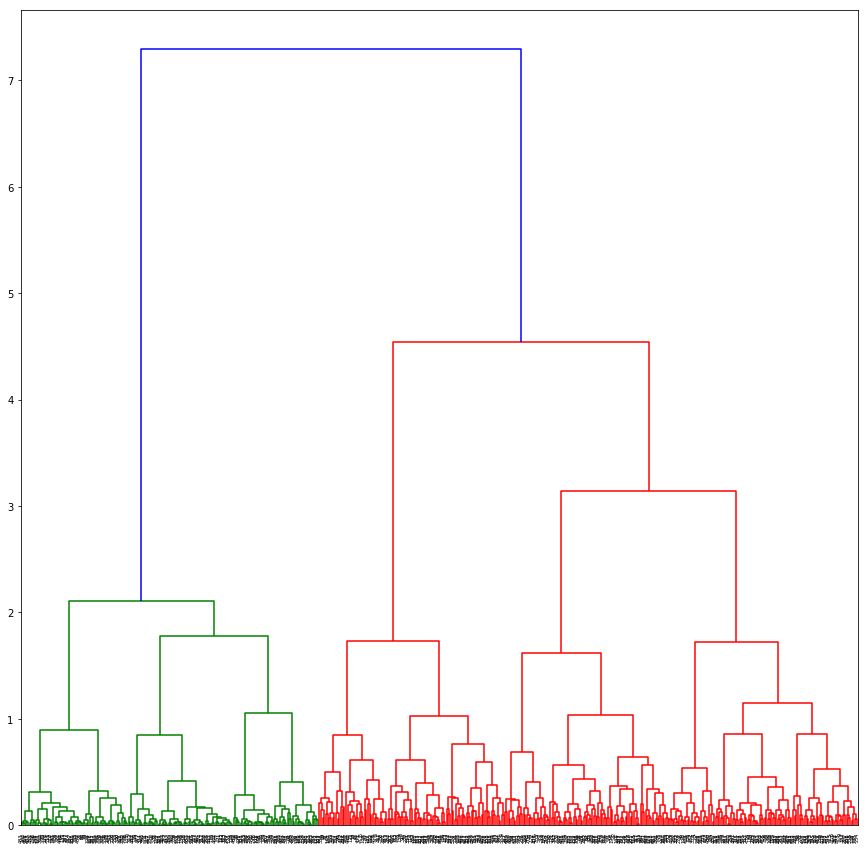

In [11]:
z = linkage(data_normalized,method='ward', metric='euclidean')
plt.figure(figsize = (15,15))
dendrogram(z)
plt.show()

Для выбора порога разбиения используем локтевой метод, из графика видно что он равен примерно 1

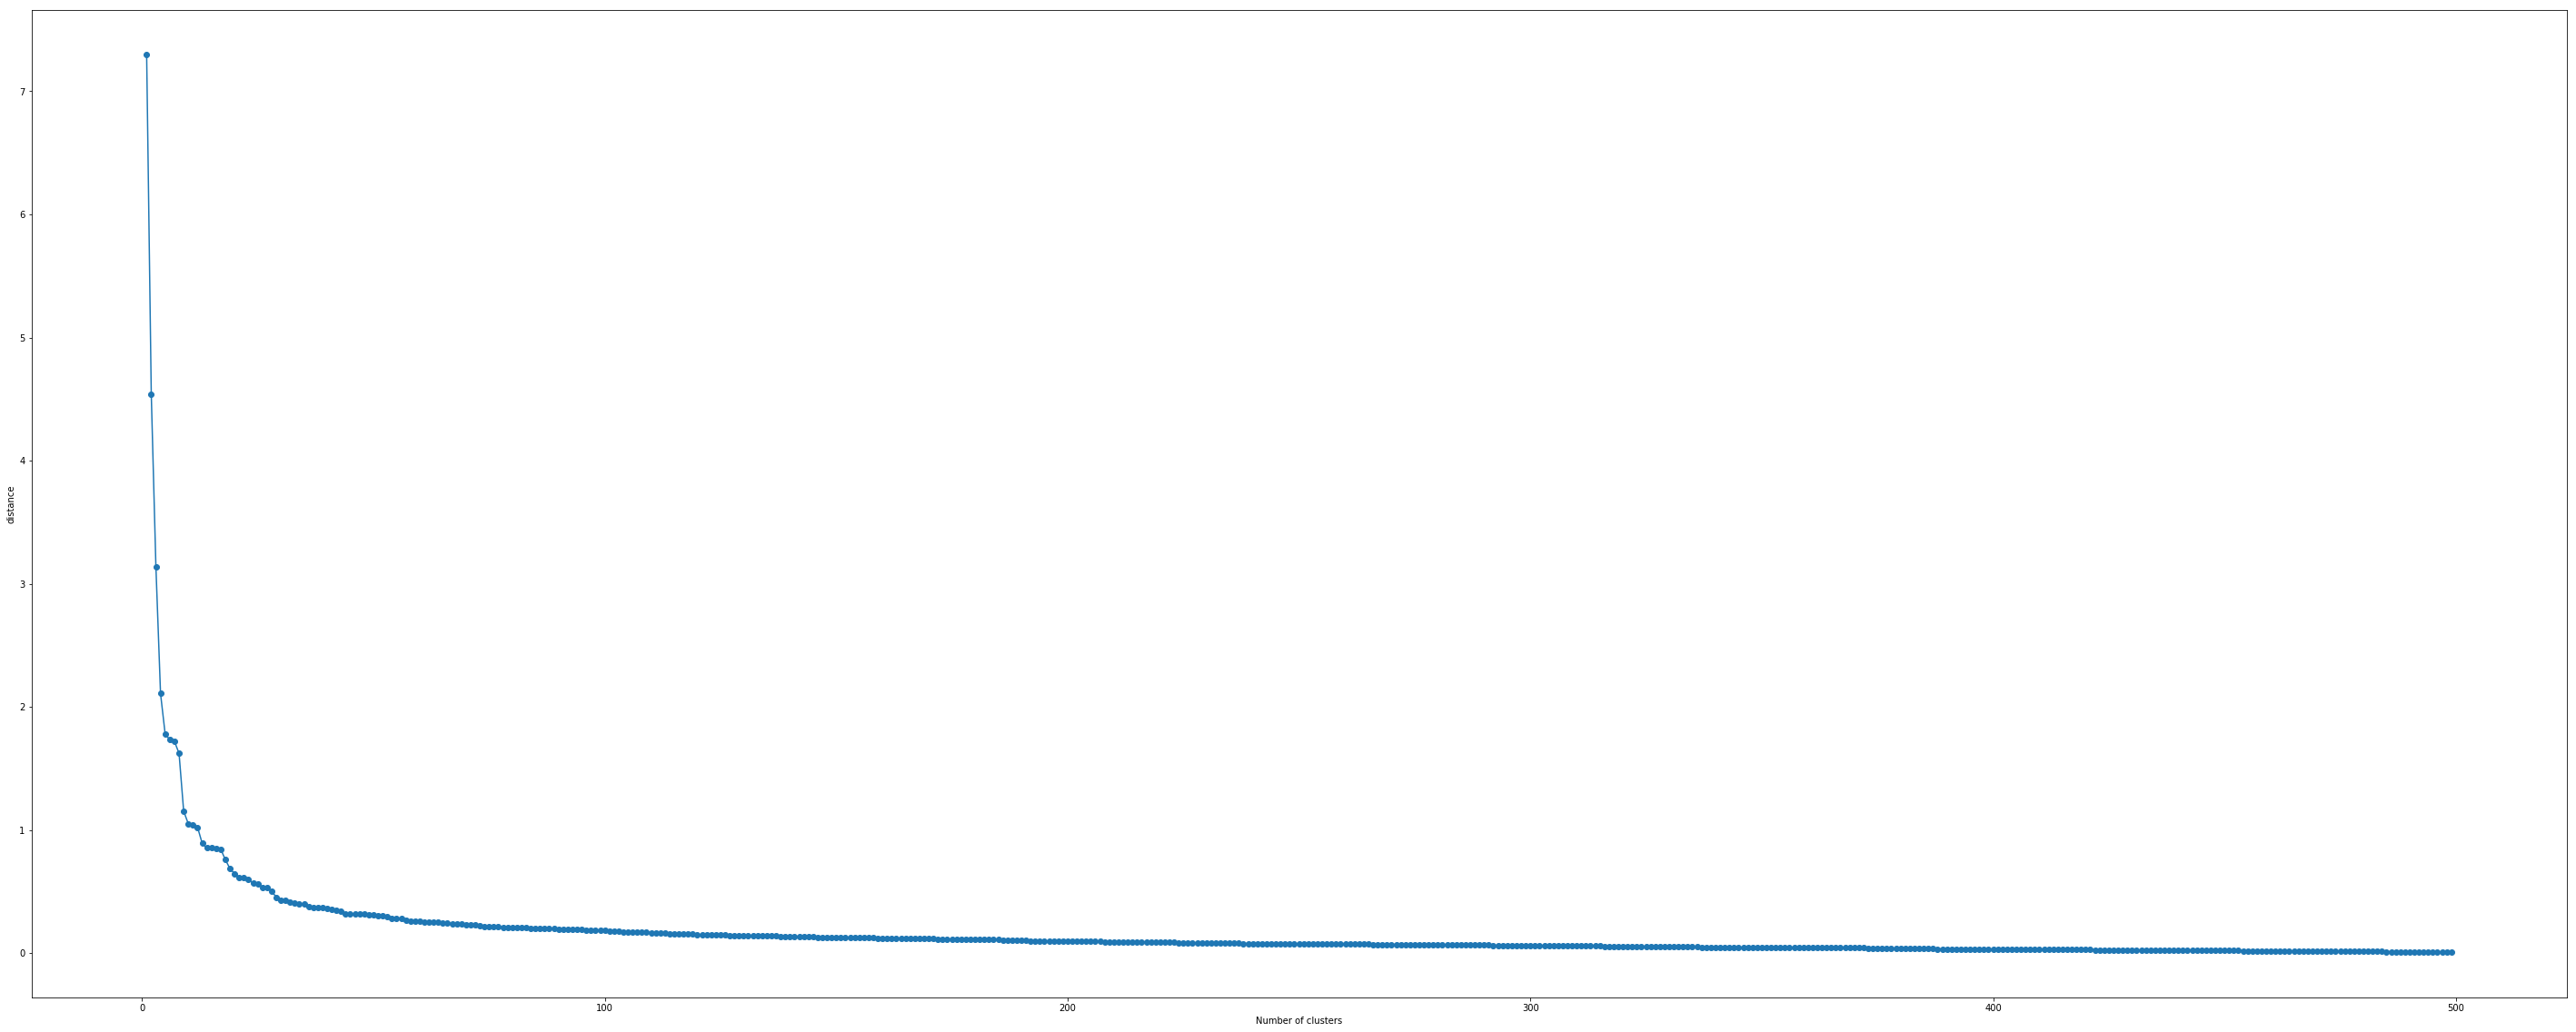

In [13]:
plt.figure(figsize=(50, 20))
plt.plot(np.array(range(1, np.shape(z)[0]+1)),
         z[:,2][::-1],
         marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("distance")
plt.show()

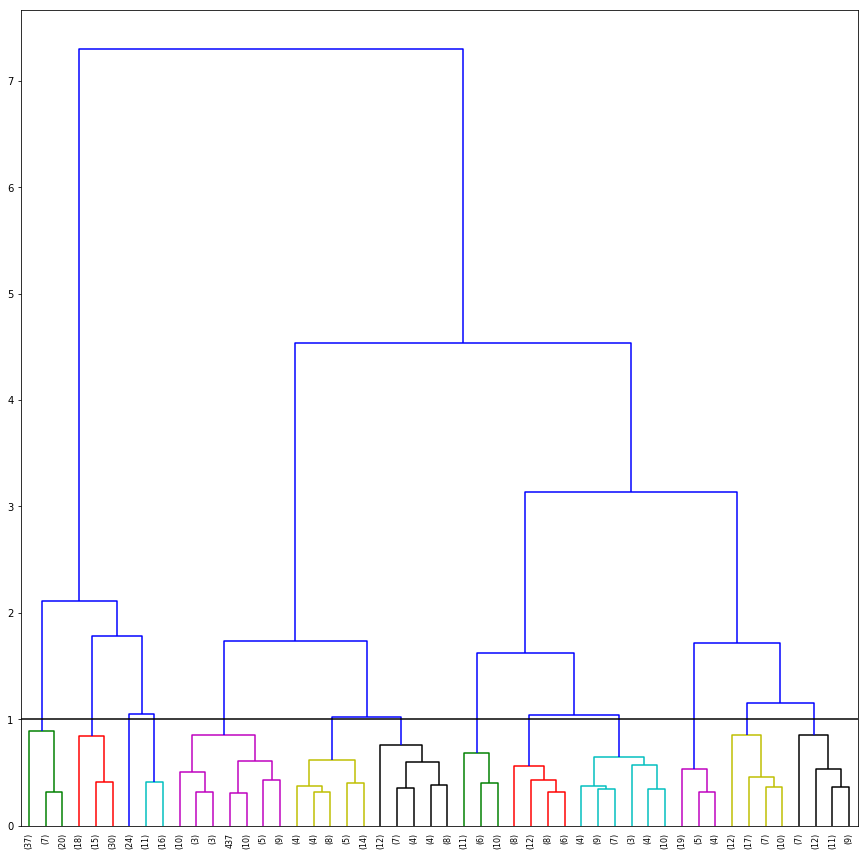

In [14]:
plt.figure(figsize = (15,15))
dendrogram(z 
           ,p=50 
           ,truncate_mode='lastp' 
           ,color_threshold=1
           #,orientation='left'
          )
plt.axhline(y=1, c='k')
plt.show()

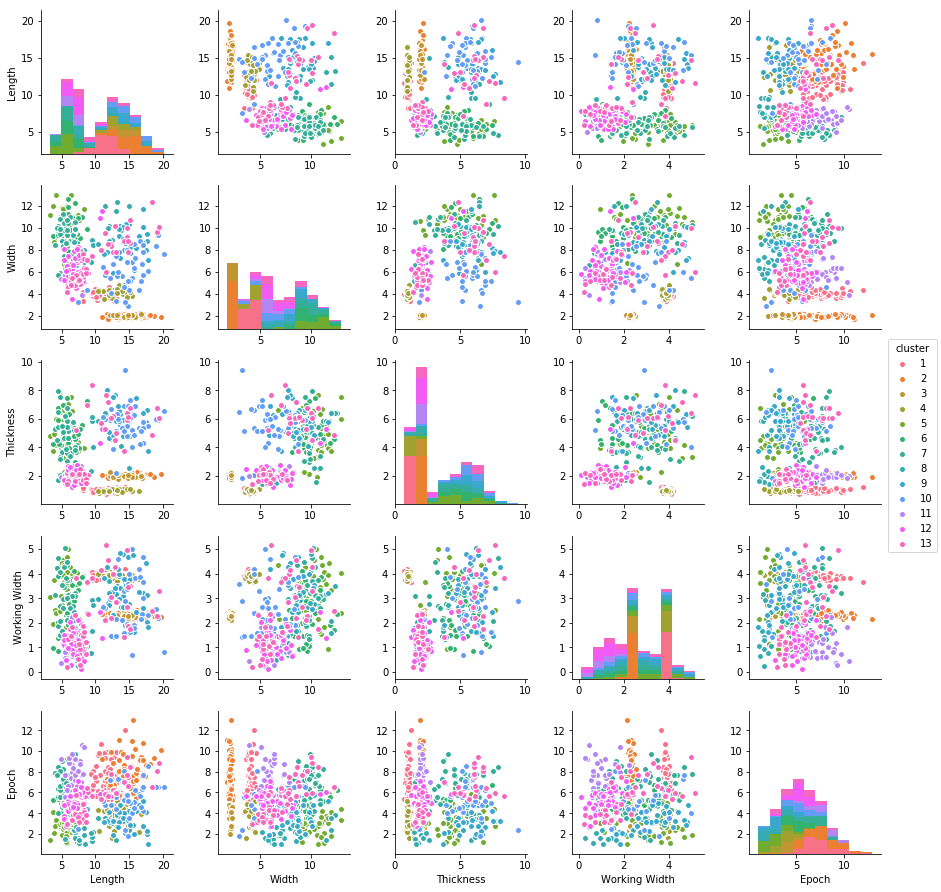

In [15]:
data_hier['cluster'] = fcluster(z,1,criterion='distance')
sns.pairplot(data_hier,hue='cluster',vars=['Length','Width','Thickness','Working Width', 'Epoch'])
plt.show()

In [79]:
hier_labels = fcluster(z,1,criterion='distance')

In [16]:
z2 = linkage(data_normalized, method = 'single')

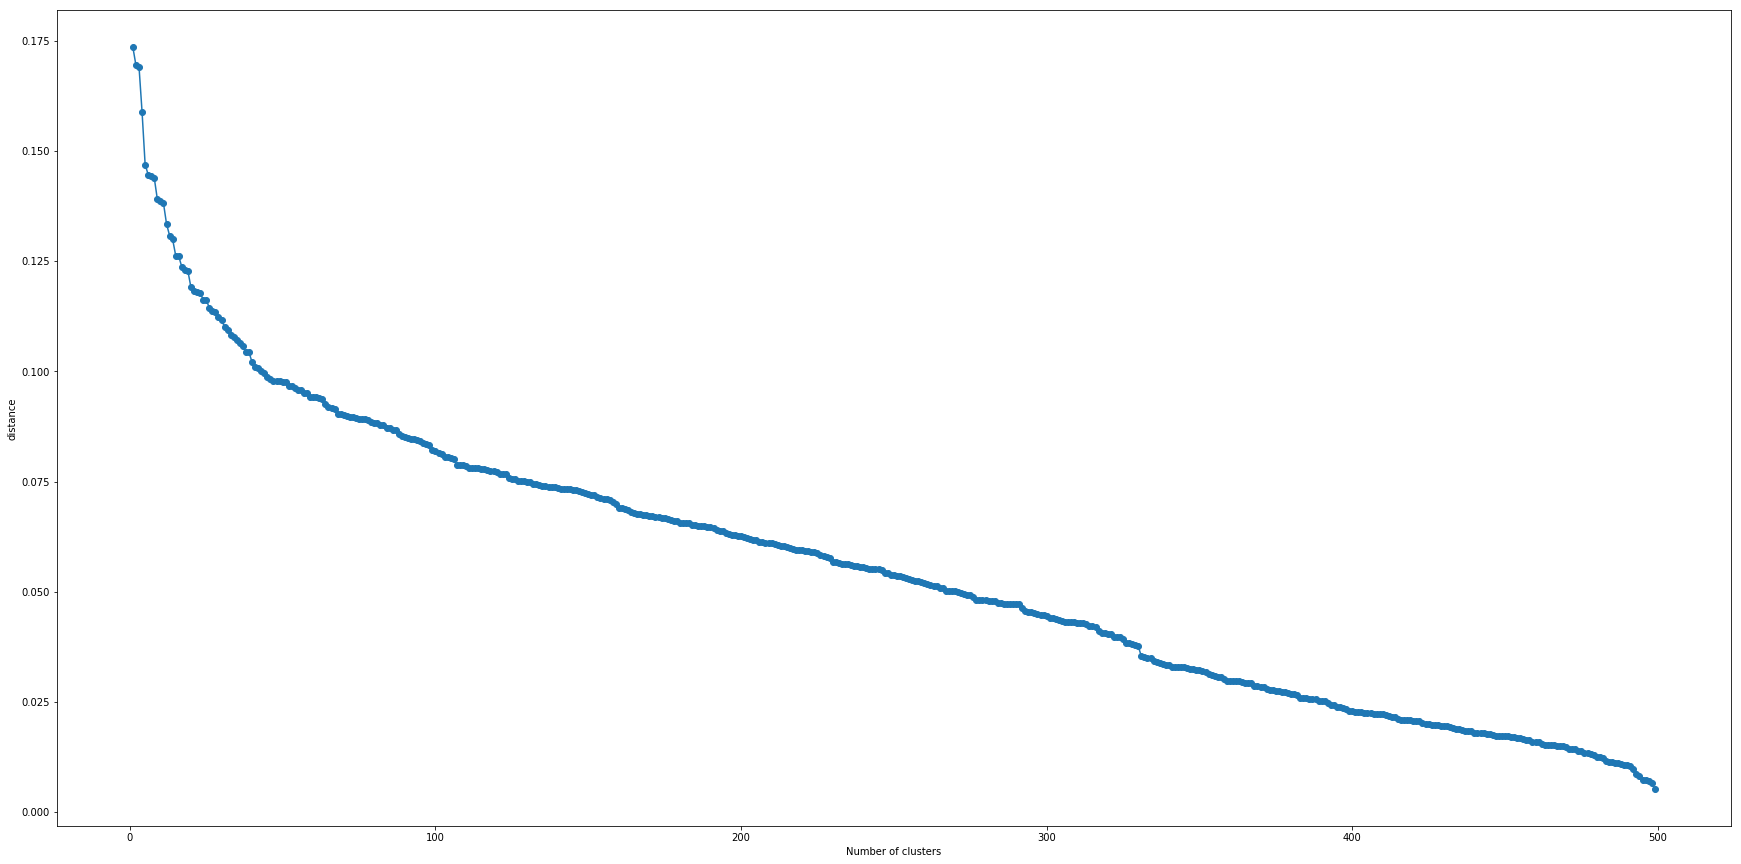

In [19]:
plt.figure(figsize=(30, 15))
plt.plot(np.array(range(1, np.shape(z2)[0]+1)),
         z2[:,2][::-1],
         marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("distance")
plt.show()

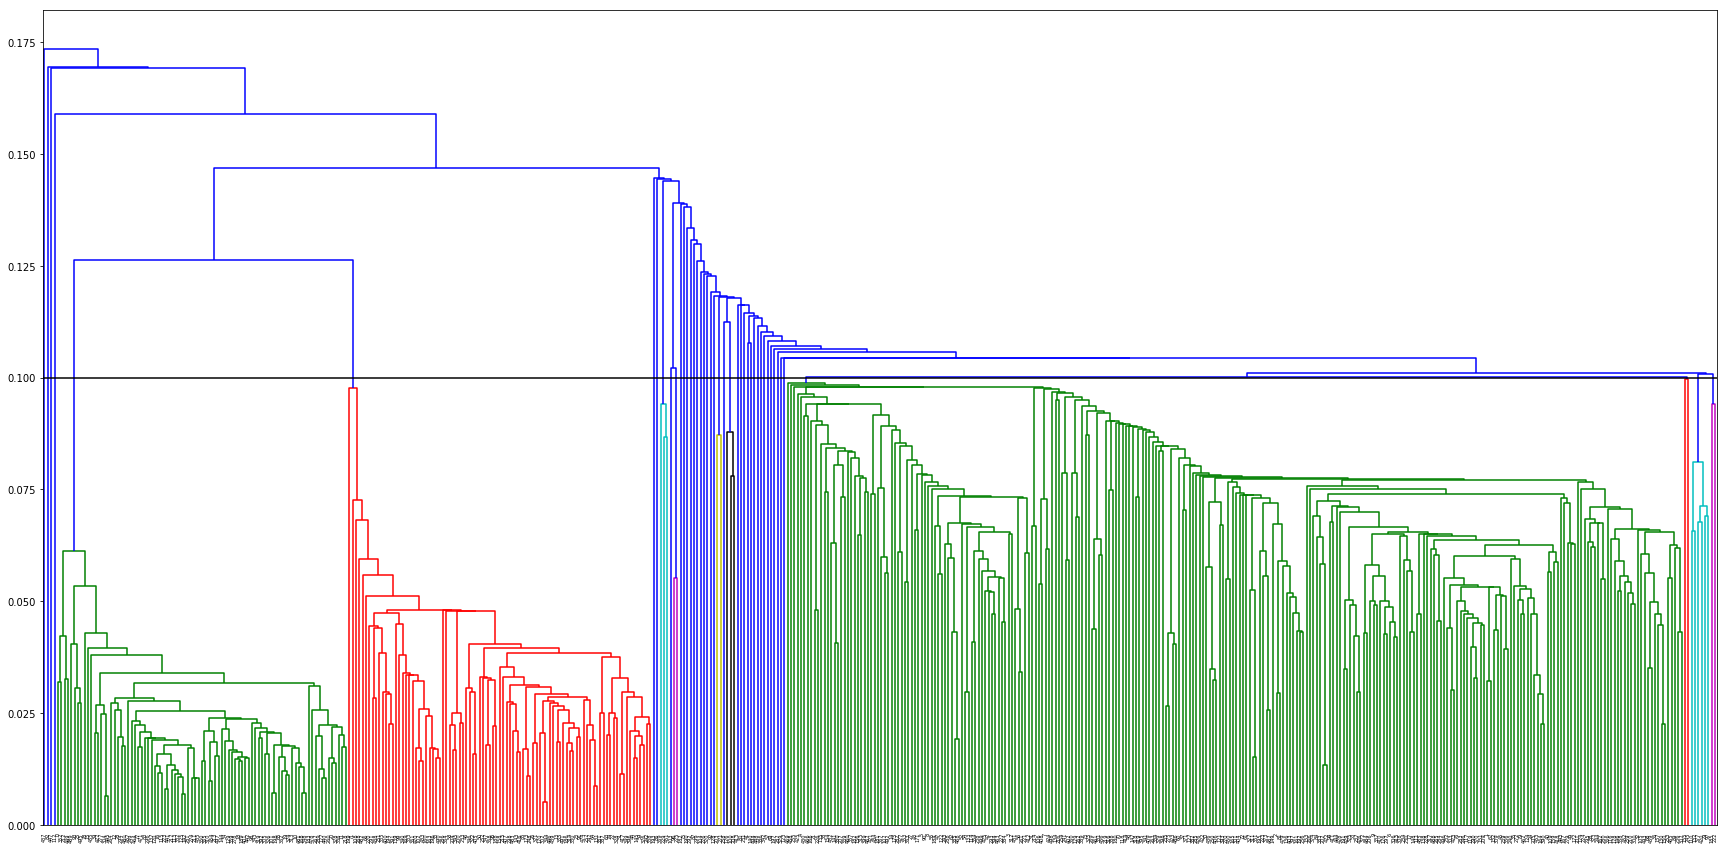

In [23]:
plt.figure(figsize = (30,15))
dendrogram(z2  
           ,color_threshold=0.1
           #,orientation='left'
          )
plt.axhline(y=0.1, c='k')
plt.show()

In [24]:
z3 = linkage(data_normalized, method = 'median')

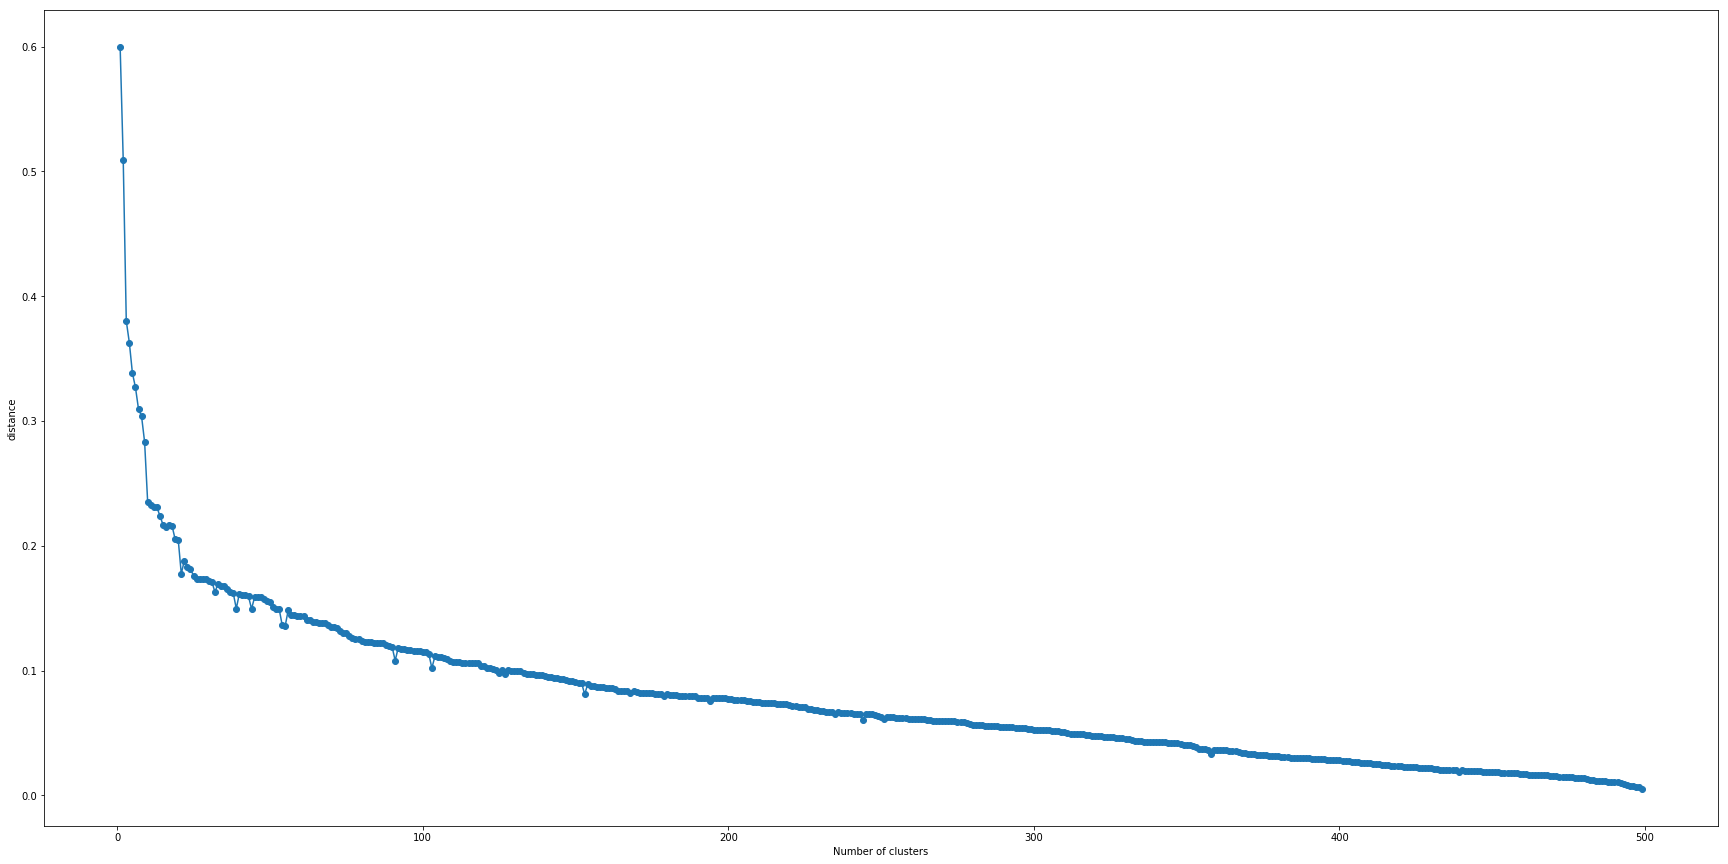

In [25]:
plt.figure(figsize=(30,15))
plt.plot(np.array(range(1, np.shape(z3)[0]+1)),
         z3[:,2][::-1],
         marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("distance")
plt.show()

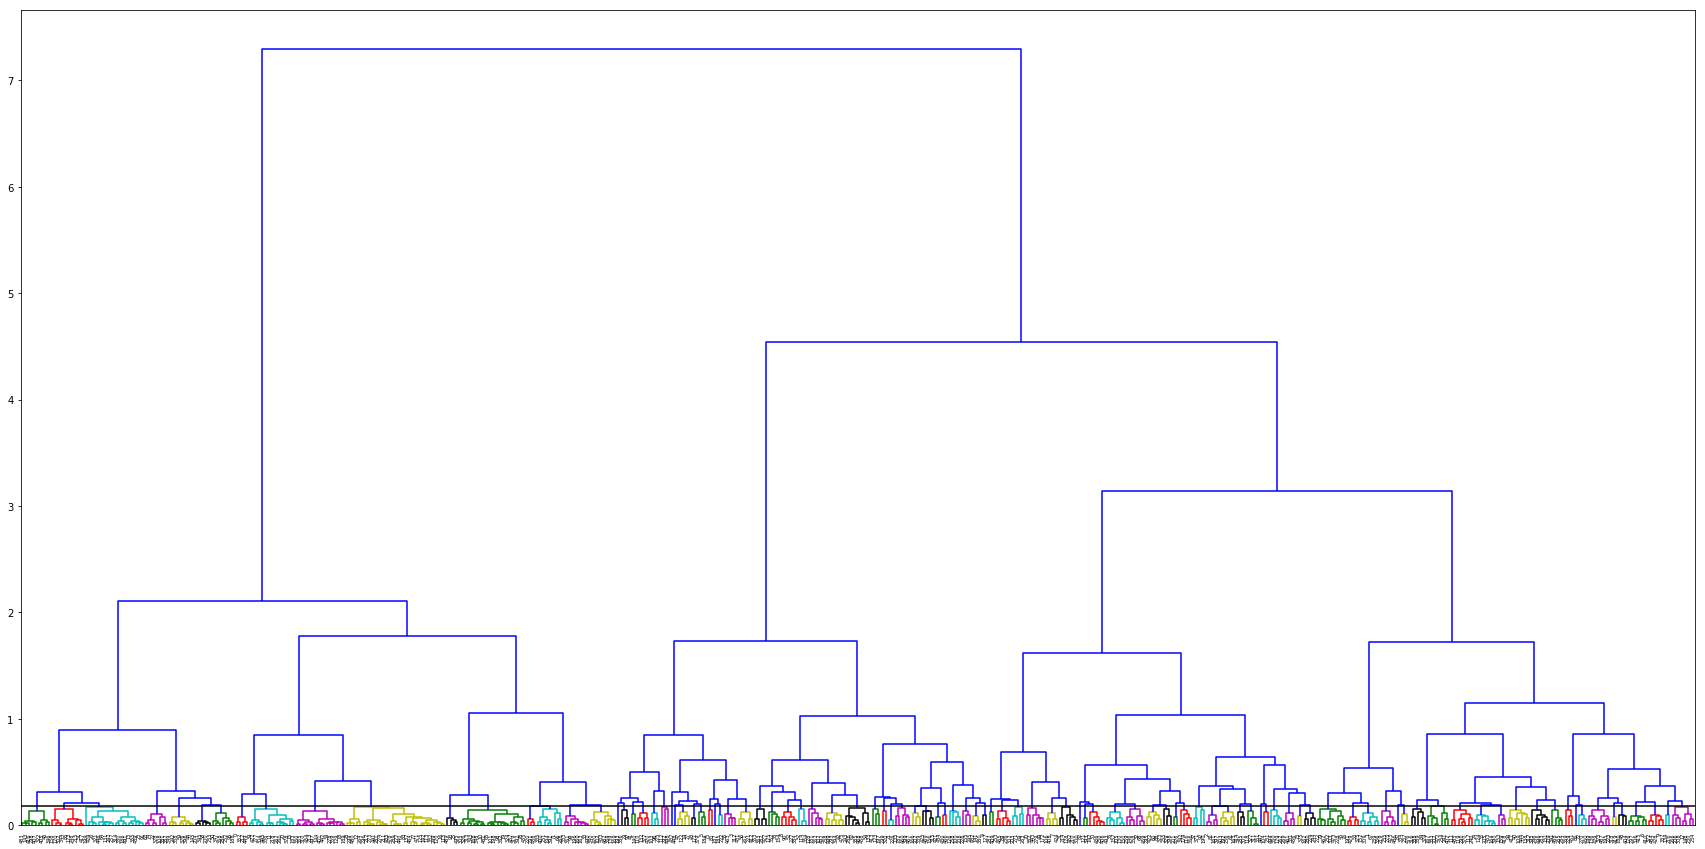

In [27]:
plt.figure(figsize=(30,15))
dendrogram(z, color_threshold=0.18)
plt.axhline(y=0.18, c='k')
plt.show()

Метод ward лучше всех разбивает наши данные

# ___ DBSCAN ___

In [28]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [29]:
data_db = data.copy()

In [51]:
db = DBSCAN(eps=0.107, min_samples=8, metric='euclidean').fit(data_normalized)
np.shape(db.labels_)
pd.Series(db.labels_).value_counts()

 1    176
 3     91
 0     87
-1     84
 2     50
 4     12
dtype: int64

При значения eps < 0.107 слишком много выбросов

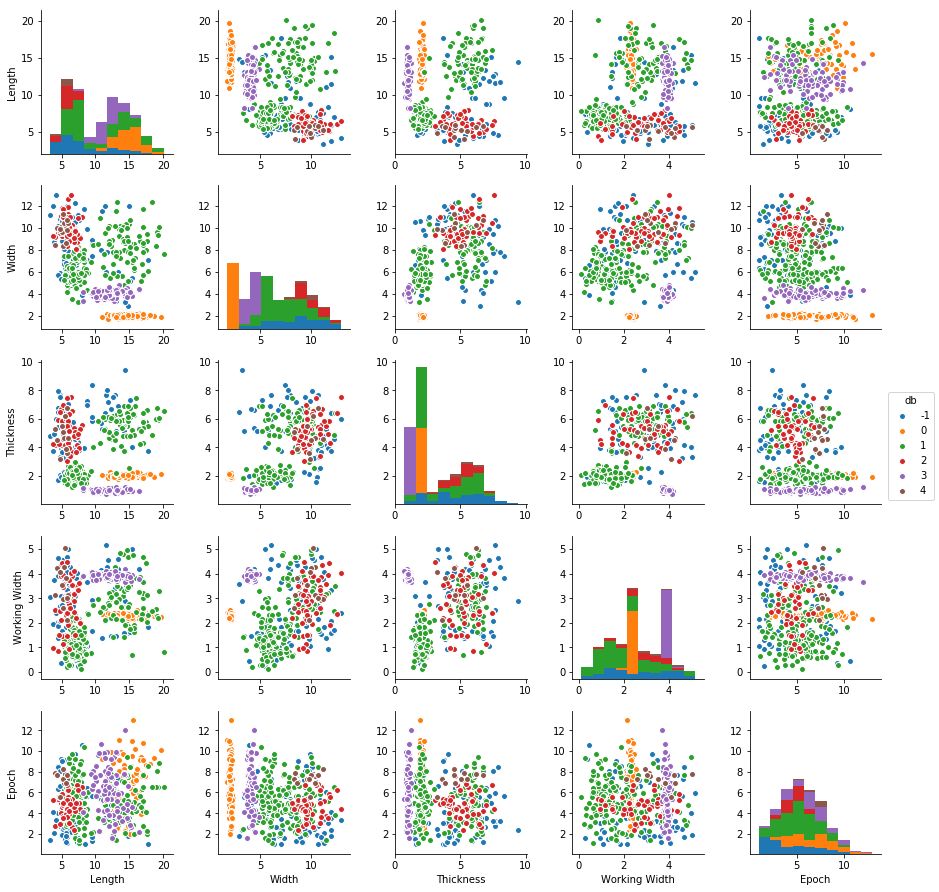

In [52]:
data_db['db'] = db.labels_

sns.pairplot(vars=["Length", "Width", "Thickness", "Working Width", "Epoch"],
             hue='db',
             data=data_db, 
             )
plt.show()

# ____ K-Means ___

In [59]:
from sklearn.cluster import KMeans

data_kmeans = data.copy()

In [54]:
Z = KMeans(n_clusters = 9, # число кластеров
           init = 'random',
           n_init = 1,
           max_iter = 100, 
           random_state=15434,
          )
Z.fit(data_normalized)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=100,
    n_clusters=9, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=15434, tol=0.0001, verbose=0)

In [55]:
Z.cluster_centers_
Z.labels_
Z.inertia_

10.199640670280758

In [60]:
centers = np.zeros((9, 5))
centers[:, 0:5] = Z.cluster_centers_
centers = pd.DataFrame(centers, columns=data_kmeans.columns)

data_kmeans['cluster'] = Z.labels_.astype(str)

centers['cluster'] = np.array(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8']).astype(str)

centers

,Length,Width,Thickness,Working Width,Epoch,cluster
0,0.766169,0.247208,0.075401,0.243133,0.523000,c0
1,0.897905,0.120927,0.121150,0.138744,0.366205,c1
2,0.738723,0.477555,0.290209,0.169217,0.299043,c2
3,0.609033,0.602730,0.191740,0.110318,0.446693,c3
4,0.402199,0.715620,0.361601,0.214659,0.338182,c4
5,0.561154,0.487997,0.181886,0.101312,0.620575,c5
6,0.869682,0.279594,0.067329,0.268221,0.281956,c6
7,0.665199,0.651729,0.250736,0.135160,0.165327,c7
8,0.828079,0.333173,0.315370,0.148141,0.243617,c8


In [57]:
data_kmeans = data_kmeans.append(centers, ignore_index=True)
data_kmeans.head(10)

,Length,Width,Thickness,Working Width,Epoch,cluster
0,13.472990,1.737486,1.940324,2.320248,11.106003,0
1,6.354988,5.721567,1.693539,1.219387,7.362391,5
2,15.646144,8.495294,6.260498,1.913487,5.068431,2
3,4.877868,10.066373,4.343533,3.909151,4.963177,4
4,5.368762,7.428465,1.798124,1.060526,6.219146,3
5,4.869873,11.117934,6.717920,4.373815,4.180283,4
6,7.755530,4.937063,2.182191,0.298420,3.837260,2
7,7.583171,6.142484,1.787883,0.648833,1.138889,7
8,5.983901,12.593497,6.428717,2.368283,6.191031,4
9,8.179001,5.550690,1.706460,1.468821,3.398491,2


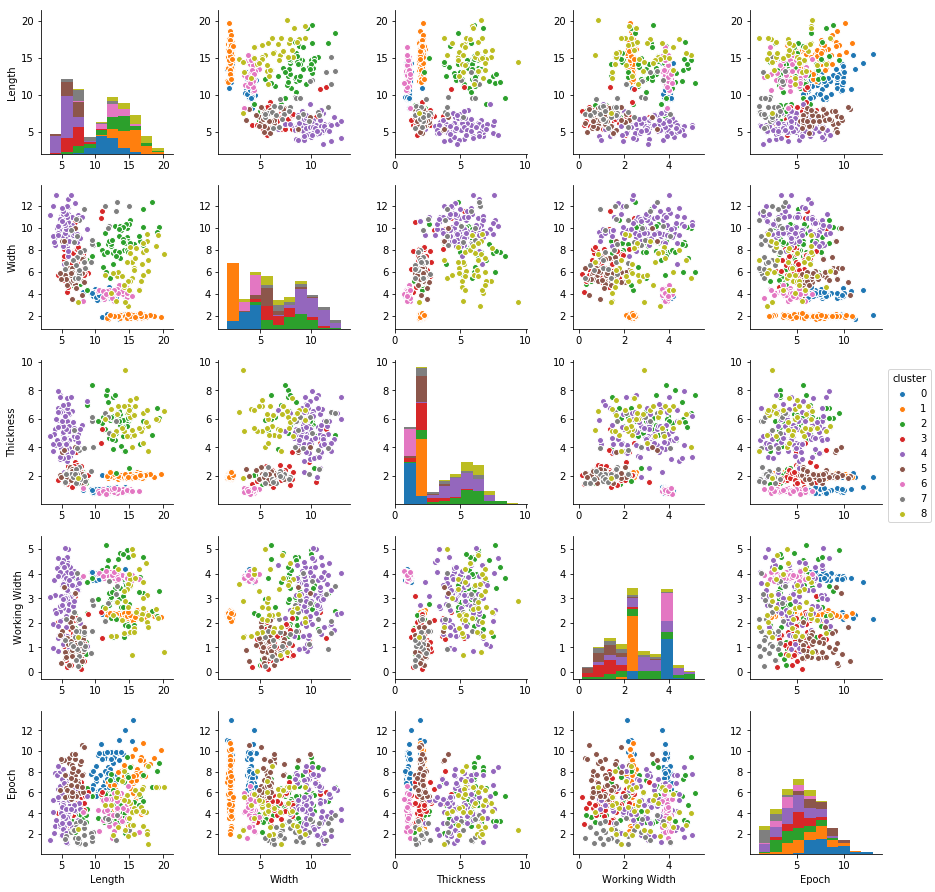

In [61]:
sns.pairplot(data_kmeans.sort_values('cluster'), 
             hue='cluster', 
             plot_kws={'alpha':1}, 
             vars=["Length", "Width", "Thickness", "Working Width", "Epoch"]
            )
plt.show()

# ___ PAM ____

In [62]:
import random
from scipy.spatial.distance import squareform

In [70]:
def PAM(data, metric, k):
    """
    Input
    data : массив или матрица - данные для обработки
    dist : string - метрика для вычисления
    k : integer - необходимое кол-во кластеров
    
    Output
    medoids : array - индексы медоид
    labels : array - метки кластеров для каждого объекта
    inertia : float - значение целевой функции
    """
    m = data.shape[0]
    dist = pdist(data, metric)
    dist = squareform(dist)
    currentMedoids = [random.randint(0, m-1) for _ in range(k)]  # случайно выбираем начальные медоиды
    #print(currentMedoids)
    oldMedoids = []
    newMedoids = []
    clusters = []
    inertia = 0
    while not (oldMedoids == currentMedoids):
        clusters = find_clusters(data, dist, currentMedoids) # распределяем данные на кластеры с данными медоидами 
        newMedoids, inertia = find_medoids(data, dist, clusters, k) # ищем новые медоиды
        #print(newMedoids,' ', inertia)
        oldMedoids = currentMedoids
        currentMedoids = newMedoids
        
    return currentMedoids, clusters, inertia
  
def find_clusters(data, dist, medoids):
    clusters = []
    for i in range(0, len(data)):
        distances = [dist[i][j] for j in medoids] 
        clusters.append(np.argmin(distances))
    return clusters

def find_medoids(data, dist, clusters, k):
    index = 0
    cost = 0
    medoids = [0 for i in range(k)]
    distances = [0 for i in range(0, len(data))]
    for i in range(0, len(data)):
        for j in range(0, len(data)):
            if clusters[j] == clusters[i]:
                distances[index] += dist[i][j] #суммарное расстояние от элемента до всех элементов данного кластера
        index += 1
    #print(pd.Series(distances).value_counts())
    
    for i in range(k):  # для каждого кластера
        d = 2*len(data)
        for n in range(0, len(data)):         
            if clusters[n] == i:
                d = min(d, distances[n])  # ищем точку снаименьшим расстоянием (ищем медоиду)
                if d == distances[n]:
                    medoids[i] = n
        cost += d                      # целевая функция для данного набора медоид
    #print(cost)
    return medoids, cost

In [71]:
medoids,labels, inertia = PAM(data_normalized, 'euclidean', 9)
inertia

67.789330670845814

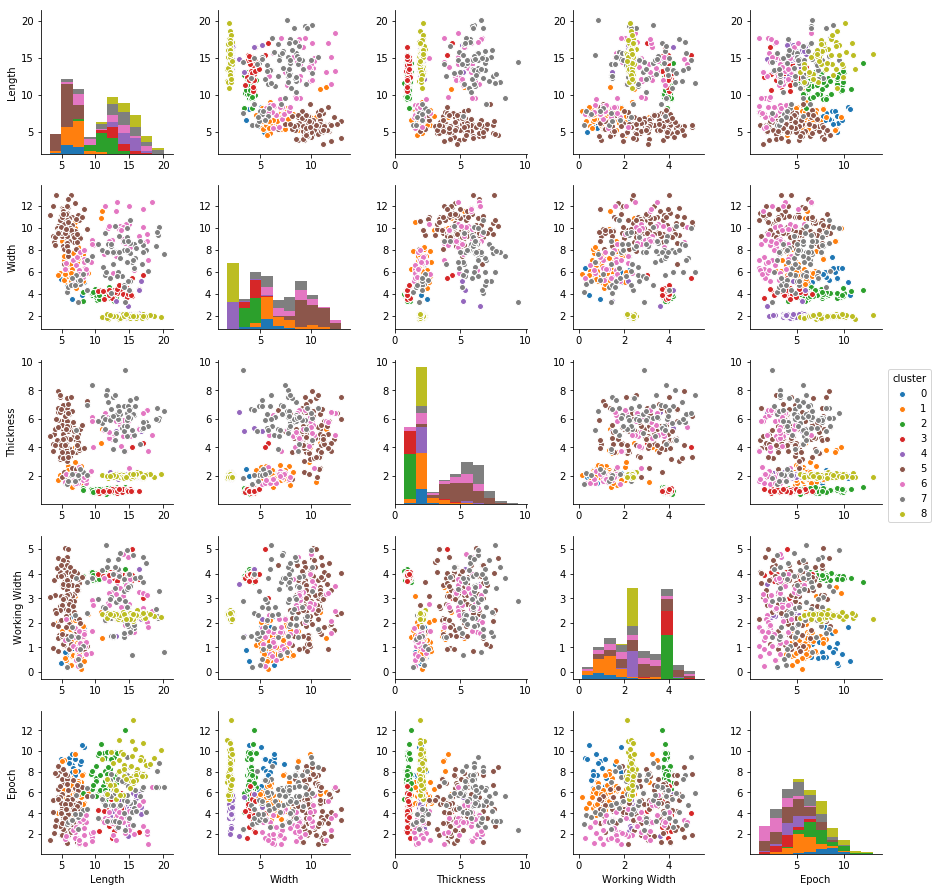

In [69]:
data_pam = data.copy()
data_pam['cluster'] = labels
sns.pairplot(data_pam.sort_values('cluster'), 
             hue='cluster', 
             plot_kws={'alpha':1}, 
             vars=["Length", "Width", "Thickness", "Working Width", "Epoch"]
            )
plt.show()

In [35]:
print(pd.Series(labels).value_counts())

7    109
5     91
8     54
4     50
0     49
1     40
3     39
2     39
6     29
dtype: int64


# Сравним разбиения с помощью метрик calinski_harabaz_score и silhouette_score

In [72]:
from sklearn import metrics

In [80]:
#metrics.silhouette_score(data_normalized, labels)
d = {'Hierarchical': [metrics.silhouette_score(data_normalized, hier_labels)],
    'K-means': [metrics.silhouette_score(data_normalized, Z.labels_)],
     'DBSCAN': [metrics.silhouette_score(data_normalized, db.labels_)], 
     'PAM' : [metrics.silhouette_score(data_normalized, labels)]}
pd.DataFrame(data=d)

,DBSCAN,Hierarchical,K-means,PAM
0,0.192872,0.28097,0.310312,0.292366


In [81]:
d2 = {'Hierarchical': [metrics.calinski_harabaz_score(data_normalized, hier_labels)],
      'K-means': [metrics.calinski_harabaz_score(data_normalized, Z.labels_)],
      'DBSCAN': [metrics.calinski_harabaz_score(data_normalized, db.labels_)], 
      'PAM' : [metrics.calinski_harabaz_score(data_normalized, labels)]}
pd.DataFrame(data=d2)

,DBSCAN,Hierarchical,K-means,PAM
0,159.412127,266.659036,300.769671,285.582223


DBSCAN образует лишь 5 кластеров и при этом много выбросов, в иерархическом методе слишком много кластеров.
Значение целевой функции в методе K-means меньше чем в PAM.

По метрикам также видно, что K-means лучше подходит для наших данных.

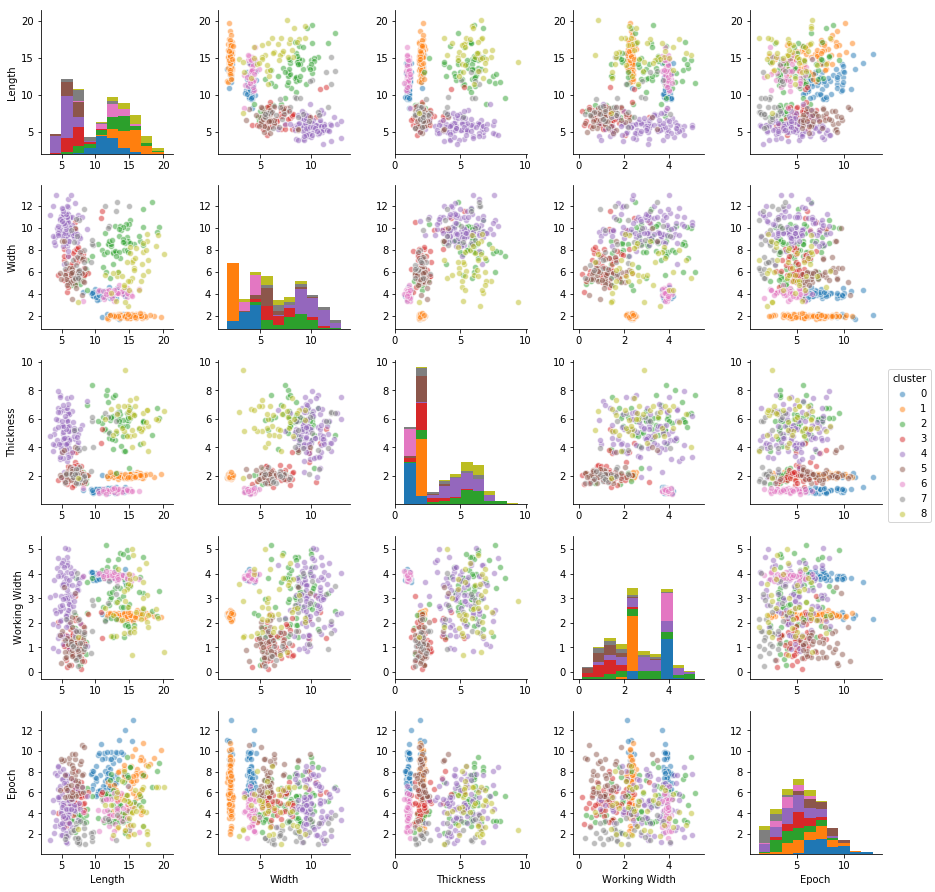

In [82]:
sns.pairplot(data_kmeans.sort_values('cluster'), 
             hue='cluster', 
             plot_kws={'alpha':0.5}, 
             vars=["Length", "Width", "Thickness", "Working Width", "Epoch"]
            )
plt.show()

# Интерпретация и Типы орудий

Интерпретация кластерам. Элементы 1-го кластера имеют маленькую ширину и толщину (около 2), достаточно длинные(от 12 до 20), среднюю Ширину рабочей части (2.5). Возможно это палка-копалка, или гарпун.Элементы 6-го кластера - у них больше ширина(4), меньше толщина (1), длина (от 10 до 15), большая ширина рабочей части (4).Скорее всего - это скребок, или первобытный молоток.    Объекты 0-го кластера - очень схожи с элементами 6-го кластера, различие только в возрасте (в два раза больше).    Объекты 3 и 5 кластера маленькие по длине(7), но широкие(4-8), средняя толщина, небольшая ширина рабочей части. Это может быть каменный нож.    Элементы 8-го кластера маленькие по длине, очень широкие и толстые.Под данные параметры подходит каменное рубило.